In [1]:
import matplotlib.pyplot as plt
from mvcl.primitives import *
from rinarak.knowledge.executor import CentralExecutor
from mvcl.model import MetaVisualLearner
from mvcl.config import config
from datasets.tdw_dataset import TDWRoomDataset
from mvcl.percept.metanet import weighted_softmax
local = not torch.cuda.is_available()
syq_path = "/Users/melkor/Documents/datasets"
wys_path = "/data3/guofang/Meta/Benchmark/MultiPaperQA/wys_try/datasets"
dataset_dir = syq_path if local else wys_path

/Users/melkor/miniforge3/envs/Melkor/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from skimage import measure
import numpy as np

def to_cc_masks(masks, threshold = 12):
    all_masks = []
    for i in range(masks.size(-1)):
        #all_labels = measure.label(masks[:,:,i])
        blobs_labels = measure.label(masks[:,:,i]>0.5, background=0)
        for cc_label in range(1,blobs_labels.max()):
            cc_mask = blobs_labels == cc_label
            if cc_mask.sum() > threshold:
                all_masks.append(cc_mask[...,None])
    all_masks = np.concatenate(all_masks, axis = -1)
    return all_masks

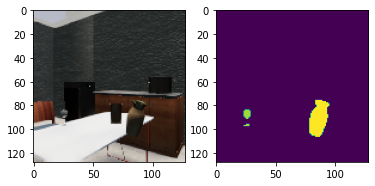

torch.Size([1, 3, 128, 128])


In [3]:
from datasets.tdw_dataset import *
resolution = (128,128)
#resolution = (64,64)
W, H = resolution
config.resolution = resolution
B, N = 1, W * H

name = "TDWKitchen"
dataset = TDWRoomDataset(name,resolution = resolution, root_dir = dataset_dir, split = "train", motion_only = True)
loader = torch.utils.data.DataLoader(dataset, batch_size = B, shuffle = True)
for sample in loader:break;
"""load the dataset and make the ideal images and masks"""

ims = sample["img"]
target_masks = sample["masks"]
masks = target_masks
plt.subplot(121)
plt.imshow(ims[0].permute(1,2,0))
plt.subplot(122)
plt.imshow(target_masks[0])
plt.show()
print(ims.shape)

In [4]:
import numpy as np
import math
num_edges = 100

def visualize_affinities(indices, affinity, im = None, num_edges = 10):
    _, B, N, K = indices.shape
    W = int(math.sqrt(N))
    indices = indices.reshape([3, B, N * K])
    rand_idx = np.random.randint(0,N * K, [num_edges])
    rand_idx = torch.tensor(rand_idx).int()
    aff = affinity.reshape(B, N * K)
    if im is None: im = torch.zeros([B,3, N])
    plt.subplot(121)
    plt.imshow(im.reshape([B,3,W,W])[0].permute(1,2,0))
    for idx in rand_idx:
        u_idx = indices[1,0,idx]
        v_idx = indices[2,0,idx]
        ux, uy = u_idx // W, u_idx % W
        vx, vy = v_idx // W, v_idx % W
        color = "green" if aff[0,idx] > 0.0 else "red"
        plt.plot([uy,vy],[ux,vx], c = color)
    plt.subplot(122)
    plt.imshow(im.reshape([B,3,W,W])[0].permute(1,2,0))

In [11]:
import torch.nn.functional as F
def uniform_pair_compare_to_zero(indices, affinity, mask1, mask2, mode = "greater"):
    """
    all inputs are logits: implication statement: forall i,j \in M1,M2, affinity i,j = 1
    """
    gc = 0.5
    tc = 2.0
    eps = 0.01
    _, B, N, K = indices.shape

    if len(mask1.shape) == 3:
        mask1 = torch.max(mask1, dim = -1).values
    if len(mask2.shape) == 3:
        mask2 = torch.max(mask2, dim = -1).values
    #print(mask1.shape, mask1.max(), mask1.min())
    #print(mask2.shape, mask2.max(), mask2.min())

    filter_u = indices[1, ...].reshape(B, N * K)
    filter_v = indices[2, ...].reshape(B, N * K)

    u_mask = torch.gather(mask1, dim = 1, index = filter_u)
    v_mask = torch.gather(mask2, dim = 1, index = filter_v)
    edge_mask = u_mask * v_mask
    
    
    #print("AffTensor",affinity, affinity.max(), affinity.min())

    aff = affinity.reshape(B, N * K).clamp(-20,20.)
    

    assert mode in ["greater", "lesser"]
    if mode == "greater": aff = aff
    if mode == "lesser": aff = -1. * aff

    probability_tensor = torch.sigmoid(
        aff / tc
    )
    #print(probability_tensor.max(), probability_tensor.min())
    #print("EdgeMask",edge_mask)
    #print("ProbTensor",probability_tensor, probability_tensor.max(), probability_tensor.min())
    
    #probability_tensor = aff

    probability_tensor = edge_mask * probability_tensor + \
     (1-edge_mask) * 1.0
    
    
    #kl_div = F.kl_div(probability_tensor, torch.ones_like(probability_tensor, device = indices.device), reduction='none')
    
    probability_log = torch.log(probability_tensor.clamp(eps, 1 - eps))
   
    forall_quantized = torch.sum(probability_log)

    #forall_quantized = kl_div.sum(-1)


    return forall_quantized

In [10]:
operator_greater_pair = Primitive(
    "greater_pair", arrow(ObjectSet, ObjectSet, Boolean, Boolean),
    lambda x: lambda y: lambda z: {uniform_pair_compare_to_zero(x["context"]["indices"],x["context"]["affinity"][z],x["end"], y["end"], "greater")}
)
operator_greater_pair = Primitive(
    "lesser_pair", arrow(ObjectSet, ObjectSet, Boolean, Boolean),
    lambda x: lambda y: lambda z: {uniform_pair_compare_to_zero(x["context"]["indices"],x["context"]["affinity"][z],x["end"], y["end"], "lesser")}
)

uniform_greater_pair = Primitive(
    "uniform", arrow(ObjectSet, Boolean, Boolean),
    lambda x: lambda y:  {**x,"end":uniform_pair_compare_to_zero(x["context"]["indices"],x["context"]["affinity"][y],x["end"], x["end"], "greater")}
)


operator_scene_cast = Primitive("mask",
                                arrow(ObjectSet, Concept, ObjectSet),
                                lambda x: lambda y: {**x,"end":x["context"]["masks"][y]})

operator_affinity_cast = Primitive("affinity",
                                   arrow(ObjectSet, Concept, ObjectSet),
                                   lambda x: lambda y: {**x,"end": x["context"]["affinity"][y]})

operator_set_union = Primitive(
    "union", arrow(ObjectSet, ObjectSet, ObjectSet),
    lambda x: lambda y: {**x,"end":torch.max(x["end"],y["end"])}
)

operator_set_union = Primitive(
    "intersect", arrow(ObjectSet, ObjectSet, ObjectSet),
    lambda x: lambda y: {**x,"end":torch.min(x["end"],y["end"])}
)
print(Primitive.GLOBALS)

Primitive("albedo", arrow(Concept), "albedo")
Primitive("texture", arrow(Concept), "texture")
Primitive("movable", arrow(Concept),"spelke")
Primitive("moving", arrow(Concept), "moving")
Primitive("object", arrow(Concept), "object")

{'scene': scene, 'exists': exists, 'forall': forall, 'equal_concept': equal_concept, 'relate': relate, 'uniform_attribute': uniform_attribute, 'equal_attribute': equal_attribute, 'assign': assign, 'if': if, 'pi': pi, 'true': true, 'false': false, 'object': object, 'pos': pos, 'color': color, 'shape': shape, 'red': red, 'blue': blue, 'green': green, 'not-any-color': not-any-color, 'square': square, 'circle': circle, 'diamond': diamond, 'not-any-shape': not-any-shape, 'left': left, 'is-good-f': is-good-f, 'greater_pair': greater_pair, 'lesser_pair': lesser_pair, 'uniform': uniform, 'mask': mask, 'affinity': affinity, 'union': union, 'intersect': intersect}


object

In [ ]:
"""
the affinity/mask pairs are listed here
color
texture
movable
moving
object
"""

'\nthe affinity/mask pairs are listed here\ncolor\ntexture\nmovable\nmoving\nobject\n'

In [5]:
from rinarak.domain import load_domain_string, Domain
domain_parser = Domain("mvcl/base.grammar")

meta_domain_str = ""
with open(f"domains/demo_domain.txt","r") as domain:
    for line in domain: meta_domain_str += line
domain = load_domain_string(meta_domain_str, domain_parser)

In [6]:
model = MetaVisualLearner(domain, config)
#model.add_affinities(["albedo"])
M = 30
device = "cpu"
model.add_affinities(["spelke"])
model.add_affinities(["albedo"])
model.add_affinities(["prox"])
model.load_state_dict(torch.load("checkpoints/phase1.ckpt", map_location="cpu"))

model = model.to(device)
model.grouper.competition.M = M
model.grouper.num_long_range = 0

In [7]:

percept_outputs = model.calculate_object_affinity(ims.to(device), working_resolution = (W, H), verbose = False)
sample_aff = percept_outputs["affinity"].clamp(-20,20.)
sample_inds = percept_outputs["indices"]


tensor(nan, grad_fn=<SumBackward0>)


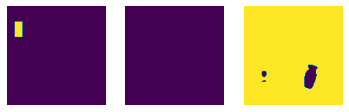

In [12]:
mask1 = (masks == 2).float().reshape([B,N]).to(device)
mask2 = (masks == 1).float().reshape([B,N]).to(device)
mask3 = (masks == 0).float().reshape([B,N]).to(device)

logp = uniform_pair_compare_to_zero(sample_inds.to(device), sample_aff.to(device), mask1.to(device), mask2.to(device))

demo_masks = torch.cat([mask1[...,None], mask2[...,None]], dim = -1)
print(logp)

mask1 = torch.zeros([B,resolution[0], resolution[1]])
mask1[:,20:40,10:20] = 1.0
mask1 = mask1.reshape([B,N])

plt.subplot(131)
plt.axis("off")
plt.imshow(mask1[0].cpu().reshape([resolution[0], resolution[1]]))
plt.subplot(132)
plt.axis("off")
plt.imshow(mask2[0].cpu().reshape([resolution[0], resolution[1]]))
plt.subplot(133)
plt.axis("off")
plt.imshow(mask3[0].cpu().reshape([resolution[0], resolution[1]]))

motion_mask = mask1[...,None]
albedo_mask = mask2[...,None]



In [15]:
programs = [
    ["(exists $0)"]
]

answers = [
    ["yes"]
]


#device = "cuda:0"
features = torch.randn([1, 5, 100]).to(device)
#masks = (torch.randn([1,128,128,5])>0.).float().to(device)
masks = {"object":motion_mask.to(device), "spelke": motion_mask.to(device) }#(torch.randn([1,128,128,5])>0.).float().to(device)
alive = 100 * torch.ones([1, 1]).to(device)
print(alive.max())

tensor(100.)


In [ ]:
#print(percept_outputs["component_affinity"])

In [16]:
outputs = model.language_grounding(percept_outputs, programs, features = features, masks = masks, alive = alive, answers = answers)

print(outputs)

{'loss': tensor(1.0729e-06), 'answers': [['yes']]}


dict_keys(['object', 'spelke', 'albedo', 'prox'])


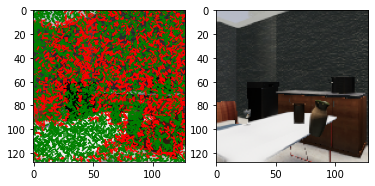

In [19]:
im = sample["img"].reshape([B, 3, W * H])
#sample_aff = percept_outputs["component_affinity"]["albedo"]
print(percept_outputs["component_affinity"].keys())
sample_aff = percept_outputs["component_affinity"]["spelke"]

visualize_affinities(sample_inds.cpu(), sample_aff.cpu(), im.cpu(), 6000)

In [ ]:
import sys
epochs = 5
optim = torch.optim.Adam(model.parameters(), lr = 1e-4)


clip_norm = 100.

for epoch in range(epochs):
    percept_outputs = model.calculate_object_affinity(ims.to(device), working_resolution = (W, H), verbose = False)
    sample_aff = percept_outputs["affinity"].clamp(-20,20.)
    sample_inds = percept_outputs["indices"]
    
    
    programs = [
    ["( uniform (mask $0 movable) albedo )"]
    ]

    answers = [
    ["true"]
    ]

    features = torch.randn([1, 5, 100]).to(device)
    masks = {"object":motion_mask.to(device), "spelke": motion_mask.to(device) }#(torch.randn([1,128,128,5])>0.).float().to(device)
    alive = 100 * torch.ones([1, 1]).to(device)
    #print(percept_outputs)
    
    #outputs = model.language_grounding(percept_outputs, programs, features = features, masks = masks, alive = alive, answers = answers)
    #loss = outputs["loss"]
    
    logp1 = uniform_pair_compare_to_zero(sample_inds.to(device), sample_aff.to(device), mask1.to(device), mask2.to(device))
    #logp2 = uniform_pair_compare_to_zero(sample_inds.to(device), sample_aff.to(device), mask1.to(device), mask1.to(device), "greater")
    
    #logp3 = uniform_pair_compare_to_zero(sample_inds.to(device), sample_aff.to(device), mask1.to(device), 1-mask1.to(device), "lesser")

    loss = -1. * logp1 #-1.* logp2-1.* logp3
    optim.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
    optim.step()
    sys.stdout.write(f"epoch{epoch+1} loss:{loss.cpu().detach().numpy()}")

percept_outputs = model.calculate_object_affinity(ims.to(device), working_resolution = (W, H), verbose = False)
sample_aff = percept_outputs["affinity"].clamp(-20,20.)
sample_inds = percept_outputs["indices"]

epoch1 loss:4116.61376953125epoch2 loss:nanepoch3 loss:nanepoch4 loss:nanepoch5 loss:nan

In [ ]:
sample_aff = percept_outputs["component_affinity"]["spelke"]
#sample_aff = percept_outputs["affinity"].clamp(-20,20.)
#print(percept_outputs["component_affinity"].keys())
#sample_aff = percept_outputs["component_affinity"]["object"].clamp(-20,20.)
#visualize_affinities(sample_inds.cpu(), sample_aff.cpu(), im.cpu(), 600)


In [22]:
model = MetaVisualLearner(domain, config)
model.add_affinities(["spelke"])
model.add_affinities(["albedo"])
model.add_affinities(["prox"])
model.load_state_dict(torch.load("checkpoints/phase1.ckpt", map_location = "cpu") )
model.grouper.num_long_range = 0

model = model.to(device)

percept_outputs = model.calculate_object_affinity(ims.to(device), working_resolution = (W, H), verbose = False)
sample_aff = percept_outputs["component_affinity"]["spelke"]
#sample_aff = percept_outputs["affinity"].clamp(-20,20.)
#print(percept_outputs["component_affinity"].keys())
#sample_aff = percept_outputs["component_affinity"]["object"].clamp(-20,20.)


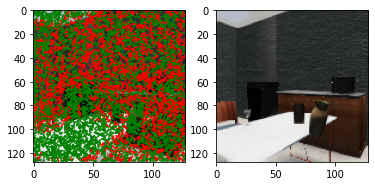

In [24]:
sample_aff = percept_outputs["component_affinity"]["spelke"]
sample_inds = percept_outputs["indices"]
visualize_affinities(sample_inds.cpu(), sample_aff.cpu(), im.cpu(), 6000)

In [26]:
import gc
gc.collect()
torch.cuda.empty_cache()

model.grouper.num_long_range = 1
percept_outputs = model.calculate_object_affinity(ims, working_resolution = (W, H), verbose = False)
obj_affinity = percept_outputs["affinity"].clamp(-20,10.)
obj_affinity = percept_outputs["component_affinity"]["albedo"]
indices = percept_outputs["indices"]

print(obj_affinity.max())
print(obj_affinity.min())

model.grouper.competition.M = 30




KeyboardInterrupt



In [ ]:
#percept_outputs["component_affinity"]["object"] = percept_outputs["affinity"].clamp(-20,10.)

In [25]:
affinity_prop_maps = []
affinity_part_masks = []

for key in percept_outputs["component_affinity"]:
    print(key)
    predict_part_masks, _ ,alive, prop_maps = model.extract_segments(percept_outputs["component_affinity"][key], indices)
    predict_part_masks = torch.einsum("bwhn,bnd->bwhn", predict_part_masks, alive)
    affinity_prop_maps.append(prop_maps)
    affinity_part_masks.append(predict_part_masks)

object


NameError: name 'indices' is not defined

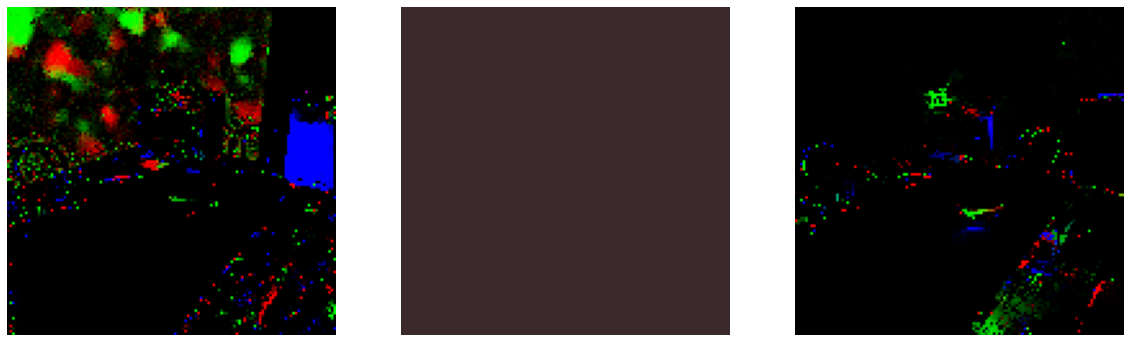

In [ ]:
num_affinity = len(affinity_part_masks)
plt.figure("kalescope", figsize = (20,20))

for k,prop_maps in enumerate(affinity_prop_maps):
        map = prop_maps[-1].reshape([W, H, -1])
        plt.subplot(1, num_affinity, k + 1)
        plt.imshow(map.detach()[...,-3:].cpu())
        plt.axis("off")

1


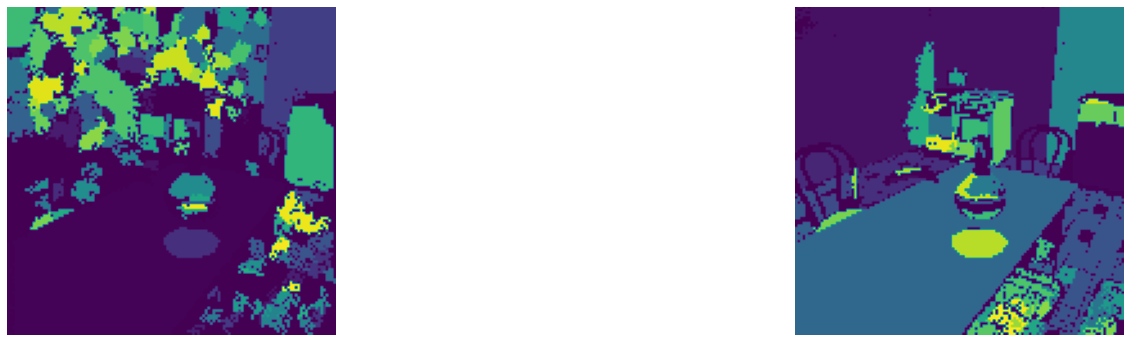

In [ ]:
num_affinity = len(affinity_part_masks)

plt.figure("affinity components",figsize = (20,20))
for idx in range(num_affinity):
    try:
        cc_masks = to_cc_masks(affinity_part_masks[idx][0].cpu())
    
        single_mask = torch.zeros([W,H])
        for i in range(cc_masks.shape[-1]):
            single_mask[cc_masks[:,:,i]] = (i+1)
        plt.subplot(1, num_affinity, idx + 1)
        plt.imshow(single_mask.int())
        
        plt.axis("off")
        plt.savefig(f"cc_mask_{idx}.png", bbox_inches = "tight")
    except:print(idx)
plt.show()
